In [53]:
import pandas as pd

data = pd.read_csv('Data_info.csv')
data = data.drop(['No', 'Name','Genre', 'LR coeff', 'MS coeff'],axis=1)
presets = pd.read_csv('Presets.csv')
presets_columns  = presets.columns

presets.head()

,Genre,RMS mean,RMS variance,RMS median,LUFS mean,LUFS variance,LUFS median,LRA mean,LRA variance,LRA median,...,DR median,Crest mean,Crest variance,Crest median,L-R mean,L-R variance,L-R median,M-S mean,M-S variance,M-S median
0,pop,0.272467,0.005007,0.306534,-9.093468,5.809389,-8.219657,2.477309,2.317275,1.878145,...,9.941894,5.389067,2.720490,4.693603,0.001106,0.000081,3.679916e-04,0.264182,0.004346,0.283951
1,orchestral,0.093511,0.002934,0.082387,-18.162032,35.545819,-17.581245,7.055114,17.366280,6.169768,...,15.483755,9.356542,12.554072,8.354993,0.000462,0.000172,1.001259e-03,0.414123,0.006171,0.449591
2,electronic,0.280681,0.009542,0.283951,-9.430143,9.087101,-8.876348,2.807858,5.115818,2.151385,...,8.076694,5.109609,2.484223,4.727758,-0.004724,0.000555,-5.800948e-04,0.267206,0.009830,0.244891
3,soul,0.220601,0.006232,0.222140,-11.141374,10.530332,-10.839213,2.923278,5.575252,2.228832,...,9.657523,6.277279,2.998605,6.176161,0.001197,0.000440,-7.320270e-04,0.238798,0.013538,0.237711
4,country,0.241329,0.006723,0.275513,-10.037742,16.826958,-8.321598,2.790272,5.186674,1.988443,...,9.002369,6.039891,8.526821,4.727211,-0.003996,0.000366,-8.791685e-07,0.272584,0.009085,0.293815


In [54]:
import yaml
import os 
import essentia
from essentia.standard import *
import IPython
import matplotlib.pyplot as plt
import numpy as np

with open('../master-dynamics/metadata/genres.yaml') as g:
    genres = yaml.load(g, Loader=yaml.FullLoader)

all_genres = set(genres.values())


# Presets configuration

Aquí hauriem de començar a analitzar les dades i establir quins seran els estàndards a partir de les dades que tenim.

In [55]:
def mean_std(data):
    columns = data.columns
    #l contain the column name, min and max in idx 0,1,2
    l = []
    for column in columns:
        mean_col = data[column].mean()
        std_col = data[column].std()
        info = [column,mean_col,std_col]
        l.append(info)
        
    return l

mean_std(data)

[['RMS', 0.23176322791717763, 0.10191692788856661],
 ['LUFS', -10.984986846075683, 4.792711580211963],
 ['LRA', 3.1761751665932234, 2.8858106784285438],
 ['N peaks', 747.6700819672132, 4130.735998945464],
 ['DR', 11.308971315983605, 8.20725051808783],
 ['Crest', 6.191779163040098, 2.6563245810048053]]

In [66]:
def normalize(values, feature, data):
    feature_indices = {'RMS': 0, 'LUFS': 1, 'LRA': 2, 'N peaks': 3, 'DR': 4, 'Crest': 5}
    feature_index = None
    for key in feature_indices:
        if feature.startswith(key):
            feature_index = feature_indices[key]
            break
    if feature_index is None:
        raise ValueError(f"Feature '{feature}' not found in dictionary")
        
    mean, std = mean_std(data)[feature_index][1], mean_std(data)[feature_index][2]
    x_norm = (values[0] - mean) / std
    x_norm = 1 + x_norm/2
    x_norm = 0 if np.isnan(x_norm) or x_norm < 0 else x_norm
    x_norm = 1 if x_norm > 1 else x_norm
    return x_norm

In [67]:
radar_data = [['RMS', 'LUFS', 'LRA', 'peaks', 'DR', 'crest']]

for genre in all_genres:
    g = presets.loc[presets['Genre'] == genre]

    for column in presets_columns:
        
        if column=='Genre':
            #initialize the list with the genre name
            gg = [g[column].values[0]]
            gg_ = []
            continue
        if column.startswith('L-R') or column.startswith('M-S'):
            continue
        if column.endswith('median') or column.endswith('variance'):
        #skip 2 iterations
            continue
            
        indx = g.columns.get_loc(column)
        #this array contains the mean, variance and median.
        values = [g.iloc[:,[indx]].values[0,0], g.iloc[:,[indx+1]].values[0,0],
                 g.iloc[:,[indx+2]].values[0,0]] 
        
        #we have to normalize a value to dorow = [] the plot
        #the normalize function must return a float between 0 and 1
        
        gg_.append(normalize(values,column,data))
    gg_ = [gg_]
    gg.append(gg_)
    radar_data.append(tuple(gg))



In [68]:
radar_data

[['RMS', 'LUFS', 'LRA', 'peaks', 'DR', 'crest'],
 ('funk', [[1, 1, 0.8630547116546075, 1, 1, 0.8967228934302248]]),
 ('house',
  [[1, 1, 0.955342041900107, 1, 0.839793871452634, 0.7372486343378872]]),
 ('classical',
  [[0.26450608602751013, 0.1526888606243284, 1, 0.9095798647636585, 1, 1]]),
 ('pop',
  [[1,
    1,
    0.8789133393157039,
    0.9745753441976399,
    0.9078079927021947,
    0.8489055653147242]]),
 ('hip-hop',
  [[1,
    1,
    0.8180925542675404,
    0.9714181183013357,
    0.9745576254965119,
    0.749122109713814]]),
 ('orchestral',
  [[0.3217392328645051, 0.2512542302233951, 1, 0.9094991688941043, 1, 1]]),
 ('rock',
  [[0.9750530613767897,
    1,
    1,
    0.9380424507535264,
    0.8665073739075131,
    0.8993676510100704]]),
 ('electronic',
  [[1, 1, 0.9361848771412317, 1, 0.8686343648143641, 0.7963030245714298]]),
 ('jazz',
  [[0.6831158178312082,
    0.7359127382453579,
    0.9917989503709156,
    0.9102052577527028,
    1,
    1]]),
 ('k-pop',
  [[1, 1, 0.8025219

## Radar chart

In [69]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

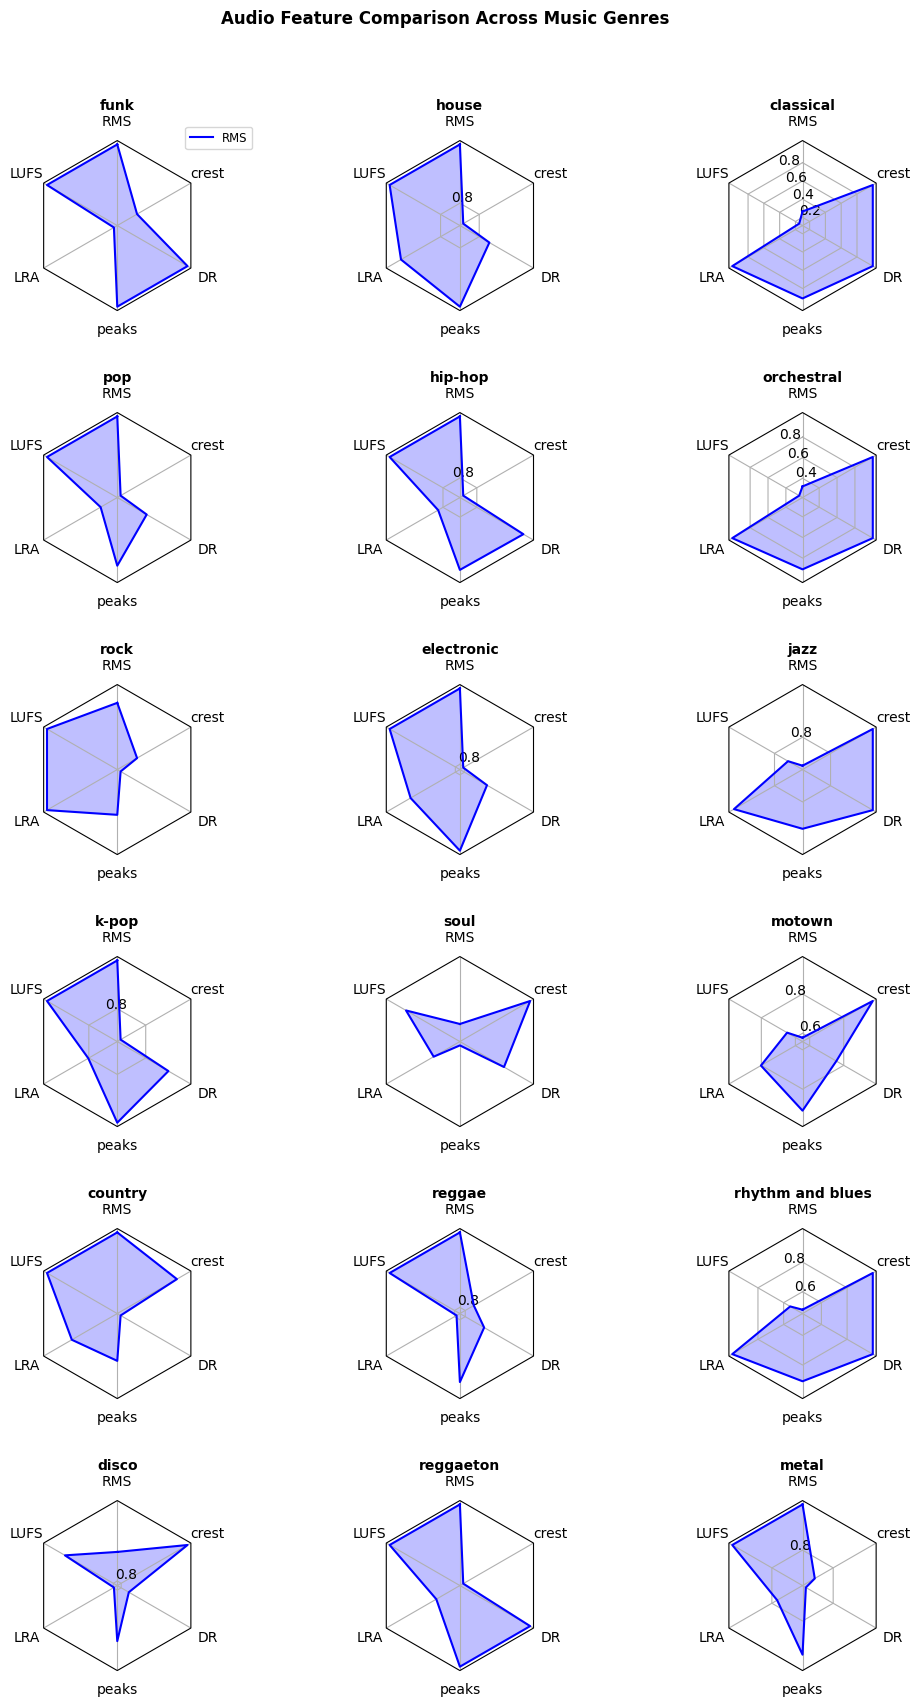

In [71]:
if __name__ == '__main__':
    N = 6
    theta = radar_factory(N, frame='polygon')

    spoke_labels = radar_data[0]
    radar_ = radar_data[1:]

    fig, axs = plt.subplots(figsize=(12, 18), nrows=6, ncols=3,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.4, hspace=0.6, top=0.9, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the cases on separate axes
    for ax, (title, case_data) in zip(axs.flat, radar_):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('RMS', 'LUFS', 'LRA', 'peaks', 'DR', 'crest')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, 'Audio Feature Comparison Across Music Genres',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

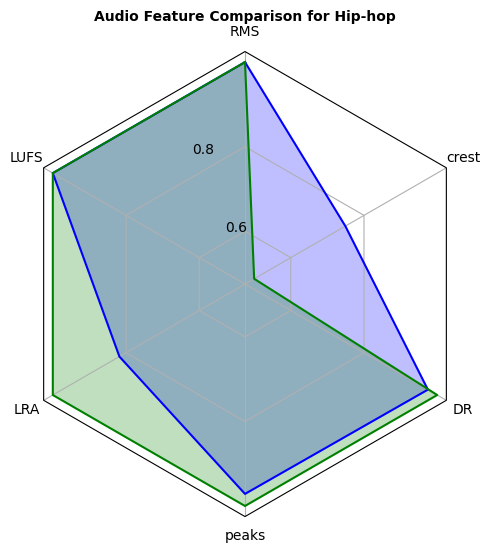

In [72]:
if __name__ == '__main__':
    N = 6
    theta = radar_factory(N, frame='polygon')

    genre, data = radar_data[5]
    song, data_song = ('song', [[1,1,1,1,1,0.5]])

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.5, top=0.85, bottom=0.05)

    # Plot the audio feature data on the axis
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(f'Audio Feature Comparison for {genre.capitalize()}', weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    ax.plot(theta, data[0], color='b')
    ax.fill(theta, data[0], facecolor='b', alpha=0.25)
    ax.plot(theta, data_song[0], color='g')
    ax.fill(theta, data_song[0], facecolor='g', alpha=0.25)
    ax.set_varlabels(radar_data[0])

    plt.show()